# Autoencoder network with MedNIST Dataset

This notebook illustrates the use of an autoencoder in MONAI for the purpose of image deblurring.

# TODO - write the learning outcomes
This will go through the steps of:
* Loading the data from a remote source
* Constructing a dataset from this data and transforms
* Defining the networks
* Training and evaluation

# TODO NEED TO DO COLAB ONCE FINISHED
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/mednist_GAN_tutorial.ipynb)

# TODO LIST
* colab links
* learning outcomes
* extraneous imports

# 1. Imports and configuration

In [1]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import torchvision 
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.engines import GanKeys, GanTrainer, default_make_latent
from monai.handlers import CheckpointSaver, MetricLogger, StatsHandler
from monai.networks import normal_init
from monai.networks.nets import AutoEncoder
from monai.transforms import (
    AddChannelD,
    Compose,
    LoadPNGD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    ToTensorD,
    Lambda,
    GaussianSmoothD,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.3.0+29.g754d1a9
Python version: 3.8.3 (default, May 19 2020, 18:47:26)  [GCC 7.3.0]
OS version: Linux (4.15.0-115-generic)
Numpy version: 1.19.2
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.0
scikit-image version: 0.17.2
Pillow version: 8.0.0
Tensorboard version: 2.3.0
gdown version: 3.12.2
TorchVision version: 0.7.0
ITK version: 5.1.1
tqdm version: 4.50.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Get the data

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/root/data/MONAI


In [4]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

### 2b Whilst debugging, alternatively use the MNIST dataset
Save to `png` so that the rest of the code is unaffected.

In [15]:
import gzip
from urllib import request
from PIL import Image

mnist_folder = os.path.join(root_dir, "MNIST")
if not os.path.exists(mnist_folder):
    os.makedirs(mnist_folder)
if len(os.listdir(mnist_folder)) < 60000:
    mnist_fname = os.path.join(root_dir, "MNIST.gz")
    if not os.path.exists(mnist_fname):
        mnist_train_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
        request.urlretrieve(mnist_train_url, mnist_fname)
    f = gzip.open(mnist_fname,'r')
    f.read(16) # Skip first 16 bytes
    image_size = 28
    num_images = 60000
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size)
    # 32x32 instead of 28x28
    data = np.pad(data, ((0,0), (2,2), (2,2)))

    for i in trange(data.shape[0]):
        im = np.squeeze(data[i])
        rescaled = (255.0 / im.max() * (im - im.min())).astype(np.uint8)
        pil_im = Image.fromarray(rescaled)
        pil_im.save(os.path.join(mnist_folder, f"mnist_{i}.png"))

100%|██████████| 60000/60000 [01:14<00:00, 803.46it/s]


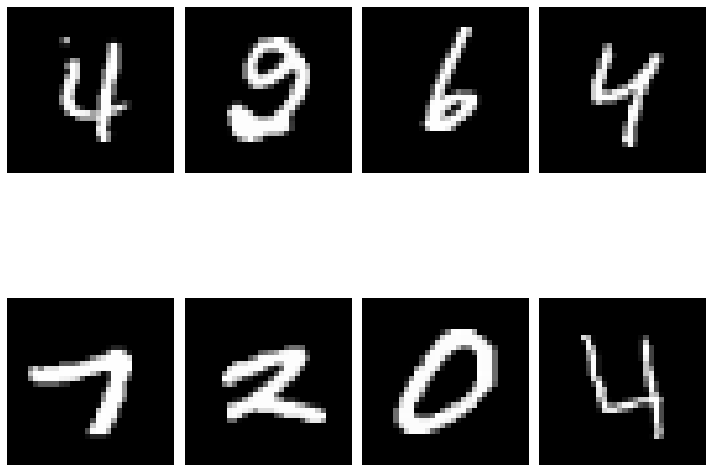

In [16]:
# Get all filenames
use_mnist = True
if True:
    im_dir = mnist_folder
else:
    im_dir = os.path.join(data_dir, "Hand")
    
all_filenames = [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plt.figure(figsize=(10,10))
for n, fname in enumerate(rand_images):
    img = plt.imread(fname)
    ax = plt.subplot(2,4,n+1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Split into training, validation and testing
val_frac = 0.1
test_frac = 0.1
num_val = int(len(all_filenames) * val_frac)
num_test = int(len(all_filenames) * test_frac)
num_train = len(all_filenames) - num_val - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
val_datadict = [{"im": fname} for fname in all_filenames[num_train:num_train+num_val]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for validation: {len(val_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 60000
number of images for training: 48000
number of images for validation: 6000
number of images for testing: 6000


# 3. Create the image transform chain

To train the autoencoder to unblur our images, we'll want to pass the blurred image into the encoder, but in the loss function, we'll do the comparison with the original, blur-free version. In this sense, the loss function will be minimised when the encode and decode steps manage to remove the blur.

Other than the fact that one version of the image and the other is not, we want them to be identical, meaning they need to be generated from the same transforms. The easiest way to do this is via dictionary transforms, where at the end, we create a copy of the image and only apply the Gaussian blur to one of the pair.

In [18]:
train_transforms = Compose(
    [
        LoadPNGD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=15, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensorD(keys=["im"]),
        Lambda(lambda d: {"orig":d["im"], "blur":d["im"]}),
        GaussianSmoothD(keys=["blur"], sigma=1.0),
    ]
)

test_val_transforms = Compose(
    [
        LoadPNGD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        ToTensorD(keys=["im"]),
        Lambda(lambda d: {"orig":d["im"], "blur":d["im"]}),
        GaussianSmoothD(keys=["blur"], sigma=3.0),
    ]
)

### Create dataset and dataloader

Hold data and present batches during training.

In [19]:
batch_size = 300
num_workers = 10

train_ds = CacheDataset(train_datadict, train_transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, test_val_transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_ds = CacheDataset(val_datadict, test_val_transforms, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Load and cache transformed data: 100%|██████████| 6000/6000 [00:18<00:00, 324.93it/s]


In [20]:
# Visualise a blurred image and its original
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)
    itera = iter(loader)
    data = next(itera)
    
    return data['orig'], data['blur']

def plot_ims(ims, titles):
    plt.subplots(1,len(ims))
    for i,(im,title) in enumerate(zip(ims,titles)):
        plt.subplot(1,len(ims),i+1)
        plt.imshow(torch.squeeze(im), cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

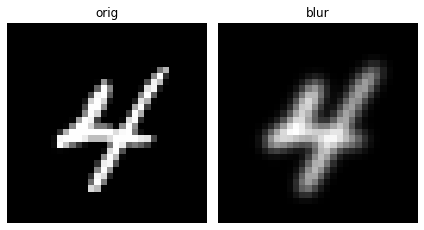

In [21]:
orig, blur = get_single_im(train_ds)
plot_ims([orig, blur],['orig', 'blur'])

In [ ]:
# create the autoencoder and move it to
# the specified device
model = AutoEncoder(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2, 2),
).to(device)

# Create loss fn and optimiser
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# optimisation variables
epoch_num = 100
# val_interval = 1
epoch_loss_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:        
        step += 1
        inputs = batch_data['orig'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, batch_data['orig'].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

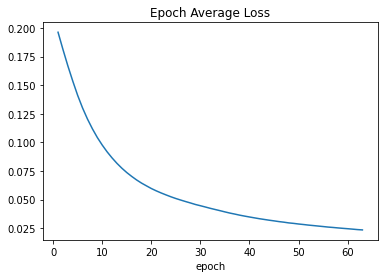

In [23]:
plt.figure()
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

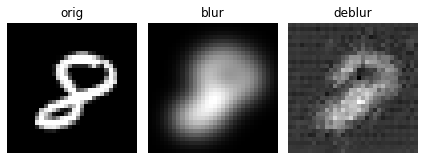

In [24]:
orig, blur = get_single_im(val_ds)
deblur = model(orig.to(device)).detach().cpu()
plot_ims([orig, blur, deblur],['orig', 'blur', 'deblur'])


### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)